In [1]:
from itertools import islice, combinations, product
from pyclustering.cluster.kmedoids import kmedoids
from scipy.spatial.distance import squareform
from collections import defaultdict
from scipy.stats import hypergeom
from collections import Counter
from goatools import obo_parser
from scipy.special import comb
from functools import partial

import os
import time
import graco
import random
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

sns.set()

In [2]:
def get_number_of_max_runs(GV, distance, nb_clusters):
    runs = max(int(run) for run,species,db,ncluster_txt in 
             map(partial(str.split, sep='_'), os.listdir(f"{CLUSTERS_DIRECTORY}/{GV}/{distance}"))
                if int(ncluster_txt.split('.')[0]) == nb_clusters)
    return runs

In [3]:
pd.set_option("display.max_columns", 50)

DATA_DIRECTORY = "/home/clusterduck123/Desktop/git/supplements/data"
CPP_DIRECTORY = "/home/clusterduck123/Desktop/git/graco/graco/cpp"

RAW_DATA_DIRECTORY = f"{DATA_DIRECTORY}/raw_data"
PPI_DIRECTORY = f"{DATA_DIRECTORY}/PPI"
ANNOTATIONS_DIRECTORY = f"{DATA_DIRECTORY}/annotations"
MATRIX_DIRECTORY = f"{DATA_DIRECTORY}/matrix"
CLUSTERS_DIRECTORY = f"{DATA_DIRECTORY}/clusters"

In [4]:
method2name = {'GDV_similarity'  : 'Tijana', 
               'GDV_mahalanobis' : 'Mahalanobis',
               'gGCV_normalizedl1'   : '$L_1$',
               'gGCV_normalizedl2'   : '$L_2$',
               'gGCV_normalizedlinf' : '$L_{\infty}$'}

# Rand Index

In [13]:
def vcomb(*args):
    return np.vectorize(partial(comb,exact=True))(*args)

def get_tp_fp_tn_fn(cooccurrence_matrix):
    tp_plus_fp = vcomb(cooccurrence_matrix.sum(0, dtype=int),2).sum()
    tp_plus_fn = vcomb(cooccurrence_matrix.sum(1, dtype=int),2).sum()
    tp = vcomb(cooccurrence_matrix.astype(int), 2).sum()
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = vcomb(cooccurrence_matrix.sum(), 2) - tp - fp - fn
    return [tp, fp, tn, fn]

def rand_index(partition1, partition2):
    D = np.array([[len(cluster1 & cluster2) for cluster1 in partition1]
                                            for cluster2 in partition2])
    
    tp,fp,tn,fn =  get_tp_fp_tn_fn(D)
    return (tp + tn) / (tp + fp + fn + tn)

In [14]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 100
MAX_RUNS = 50

In [17]:
partitions = defaultdict(list)

methods = ['GDV_similarity', 'GDV_mahalanobis', 'gGCV_normalizedl1', 'gGCV_normalizedl2', 'gGCV_normalizedlinf']
for method in methods:
    GV, distance = method.split('_')
    for run in range(MAX_RUNS):
        for nb_clusters in [10]:
            with open(f"{CLUSTERS_DIRECTORY}/{GV}/{distance}/{run}_sc_BioGRID_{nb_clusters}.txt", 'r') as f:
                partitions[method].append([set(line.split()) for line in f])

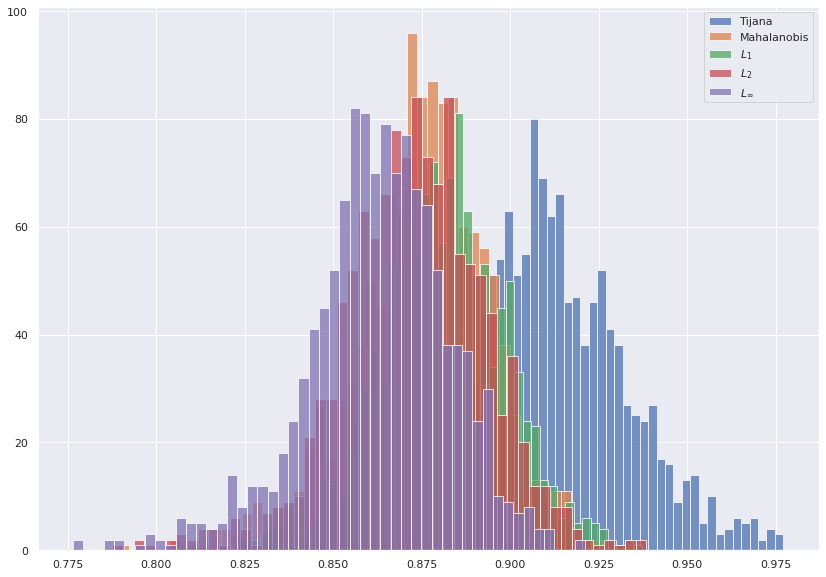

In [18]:
fig, ax = plt.subplots(figsize=(14,10))
for method in methods:
    D = [rand_index(partition1, partition2) for partition1, partition2 in combinations(partitions[method],2)]
    plt.hist(D, bins=50, alpha=0.75, label=method2name[method]);
plt.legend();

# Jaccard index

In [4]:
def jaccard(set1,set2):
    return len(set1 & set2) / len(set1 | set2)

def gene2cluster_idx(gene, partition):
    for cluster_idx, cluster in enumerate(partition):
        if gene in cluster:
            return cluster_idx
        
def gene2cluster(gene, partition):
    for cluster in partition:
        if gene in cluster:
            return cluster

In [5]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 100
MAX_RUNS = 50

In [6]:
methods = ['GDV_similarity']
clusters = []
for method in methods:
    GV, distance = method.split('_')
    
    for run in range(MAX_RUNS):
        for nb_clusters in [10]:
            with open(f"{CLUSTERS_DIRECTORY}/{GV}/{distance}/{run}_sc_BioGRID_{nb_clusters}.txt", 'r') as f:
                clusters.append([set(line.split()) for line in f])

In [7]:
PPI = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")
N = len(PPI)

In [17]:
%%time

a = 0
b = 0
c = 0
d = 0

#for cluster in clusters[0]:
#    for gene1,gene2 in combinations(cluster,2):
#        cluster_idx1 = gene2cluster_idx(gene1,clusters[1])
#        if gene2 in clusters[1][cluster_idx1]:
#            a += 1
#        else:
#            c += 1
            
for gene1, gene2 in combinations(PPI,2):
    cluster_idx11 = gene2cluster_idx(gene1,clusters[0])
    cluster_idx21 = gene2cluster_idx(gene1,clusters[1])
    if   gene2 in clusters[0][cluster_idx11] and gene2 in clusters[1][cluster_idx21]:
        a += 1
    elif gene2 in clusters[0][cluster_idx11] and not gene2 in clusters[1][cluster_idx21]:
        c += 1
    elif gene2 not in clusters[0][cluster_idx11] and gene2 in clusters[1][cluster_idx21]:
        d += 1
    elif gene2 not in clusters[0][cluster_idx11] and gene2 not in clusters[1][cluster_idx21]:
        b += 1
    else:
        raise Exception

CPU times: user 19.2 s, sys: 0 ns, total: 19.2 s
Wall time: 19.3 s


In [26]:
a2 = 0
b2 = 0
c2 = 0
d2 = 0

for cluster in clusters[0]:
    for gene1,gene2 in combinations(cluster,2):
        cluster_idx1 = gene2cluster_idx(gene1,clusters[1])
        if gene2 in clusters[1][cluster_idx1]:
            a2 += 1
        else:
            c2 += 1

for cluster1, cluster2 in combinations(clusters[0],2):
    for gene1,gene2 in product(cluster1,cluster2):
        if gene2 in gene2cluster(gene1,clusters[1]):
            d2 += 1
        else:
            b2 += 1

In [27]:
print((a2+b2)/(a2+b2+c2+d2))

0.9310880729439147


In [8]:
D = np.array([[len(cluster1 & cluster2) for cluster1 in clusters[0]]
                                        for cluster2 in clusters[1]])

In [9]:
from scipy.special import comb

In [10]:
def get_tp_fp_tn_fn(cooccurrence_matrix, comb):
    tp_plus_fp = comb(cooccurrence_matrix.sum(0, dtype=int),2).sum()
    tp_plus_fn = comb(cooccurrence_matrix.sum(1, dtype=int),2).sum()
    tp = comb(cooccurrence_matrix.astype(int), 2).sum()
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(cooccurrence_matrix.sum(), 2) - tp - fp - fn
    return [tp, fp, tn, fn]

In [11]:
tp,fp,tn,fn =  get_tp_fp_tn_fn(D, np.vectorize(partial(comb, exact=True)))

print("Rand index: %f" % (float(tp + tn) / (tp + fp + fn + tn)))

Rand index: 0.931088


In [14]:
def vcomb(*args):
    return np.vectorize(partial(comb,exact=True))(*args)

def get_tp_fp_tn_fn(cooccurrence_matrix):
    tp_plus_fp = vcomb(cooccurrence_matrix.sum(0, dtype=int),2).sum()
    tp_plus_fn = vcomb(cooccurrence_matrix.sum(1, dtype=int),2).sum()
    tp = vcomb(cooccurrence_matrix.astype(int), 2).sum()
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = vcomb(cooccurrence_matrix.sum(), 2) - tp - fp - fn
    return [tp, fp, tn, fn]

def rand_index(partition1, partition2):
    D = np.array([[len(cluster1 & cluster2) for cluster1 in partition1]
                                            for cluster2 in partition2])
    
    tp,fp,tn,fn =  get_tp_fp_tn_fn(D)
    return (tp + tn) / (tp + fp + fn + tn)

In [16]:
%%timeit
rand_index(clusters[0], clusters[1])

1.24 ms ± 16.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
50*51/2 * 0.00124

1.581